# Import Libraries

In [53]:
!pip install -q statsmodels

In [54]:
# Random seed for reproducibility
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

from pickle import dump,load

In [55]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [56]:
from collections import defaultdict
from statsmodels.tsa.stattools import acf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import time

# Load Data

In [57]:
ds = np.load("/kaggle/input/homework2timeseries/training_data.npy")
categories = np.load("/kaggle/input/homework2timeseries/categories.npy")
valid_periods = np.load('/kaggle/input/homework2timeseries/valid_periods.npy')

In [58]:
# Fit and transform the string labels to integer labels
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(categories)

In [59]:
print("dataset Shape:", ds.shape)
print("labels Shape:", integer_labels.shape)

dataset Shape: (48000, 2776)
labels Shape: (48000,)


# Inspect Data

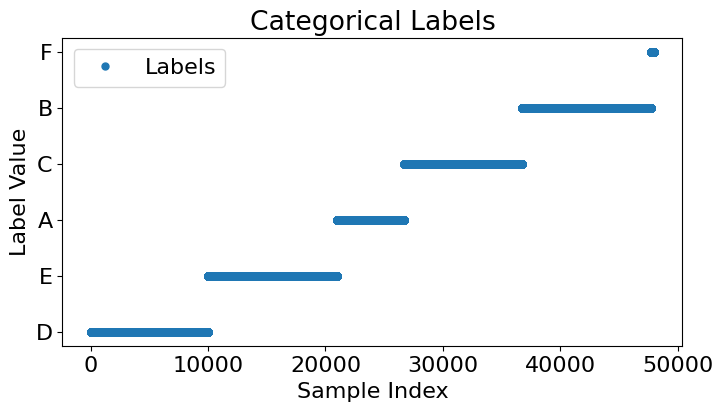

In [60]:
# Plot labels
plt.figure(figsize=(8, 4))
plt.plot(categories, marker='o', linestyle='None', markersize=5, label='Labels')
plt.title('Categorical Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.legend()
plt.show()

In [ ]:
import os
import tensorflow as tf
import numpy as np

class model:

    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):      
        
        window = 60
        X = X[:, -window:]
        X = np.expand_dims(X, axis=-1)
        reg_future = np.array([])
        X_temp = X
        for reg in range(0,18,9):
            pred_temp = self.model.predict(X_temp)
            if(len(reg_future)==0):
                reg_future = pred_temp
            else:
                reg_future = np.concatenate((reg_future,pred_temp),axis=1) 
            X_temp = np.concatenate((X_temp[:,9:],pred_temp), axis=1)
        out = np.squeeze(reg_future, axis=-1)
        
        return out

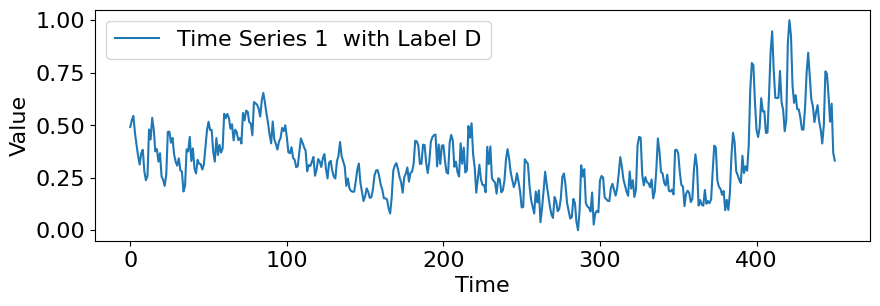

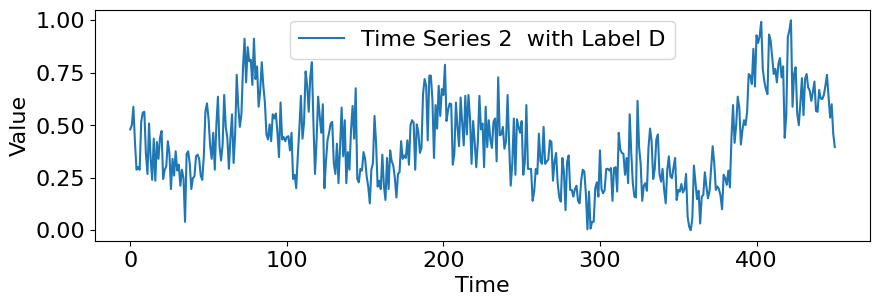

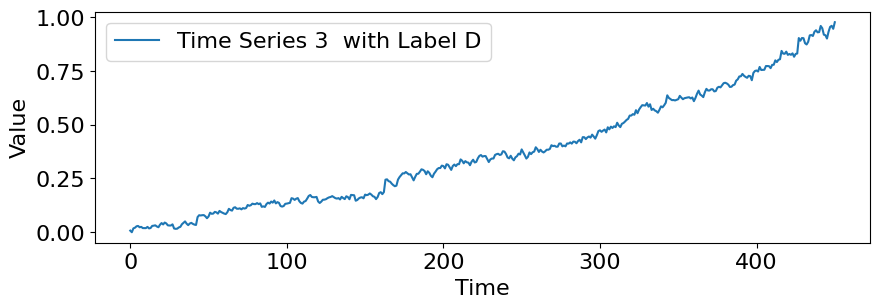

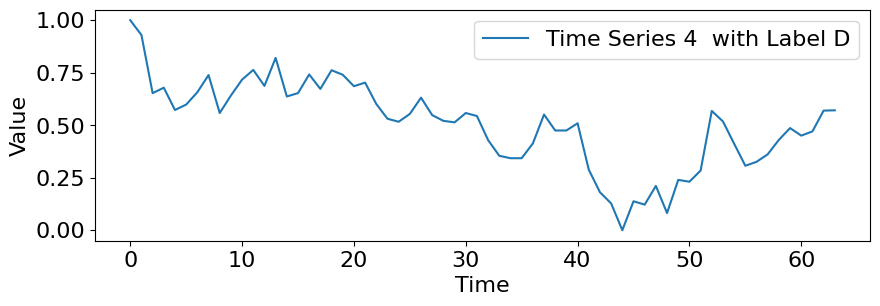

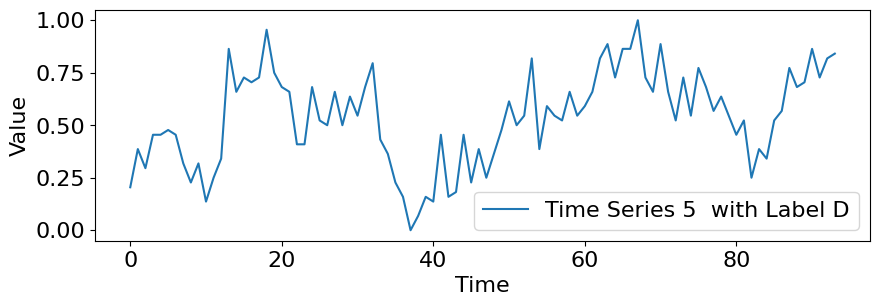

In [61]:
original_dataset = []
for i, (start, end) in enumerate(valid_periods):
    original_dataset.append(ds[i, start:end])

for i in range(5):
    plt.figure(figsize=(10, 3))
    plt.plot(original_dataset[i], label=f'Time Series {i+1}  with Label {categories[i]}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

i : 9 allocated to element : D
i : 10025 allocated to element : E
i : 21000 allocated to element : A
i : 26728 allocated to element : C
i : 36745 allocated to element : B
i : 47732 allocated to element : F


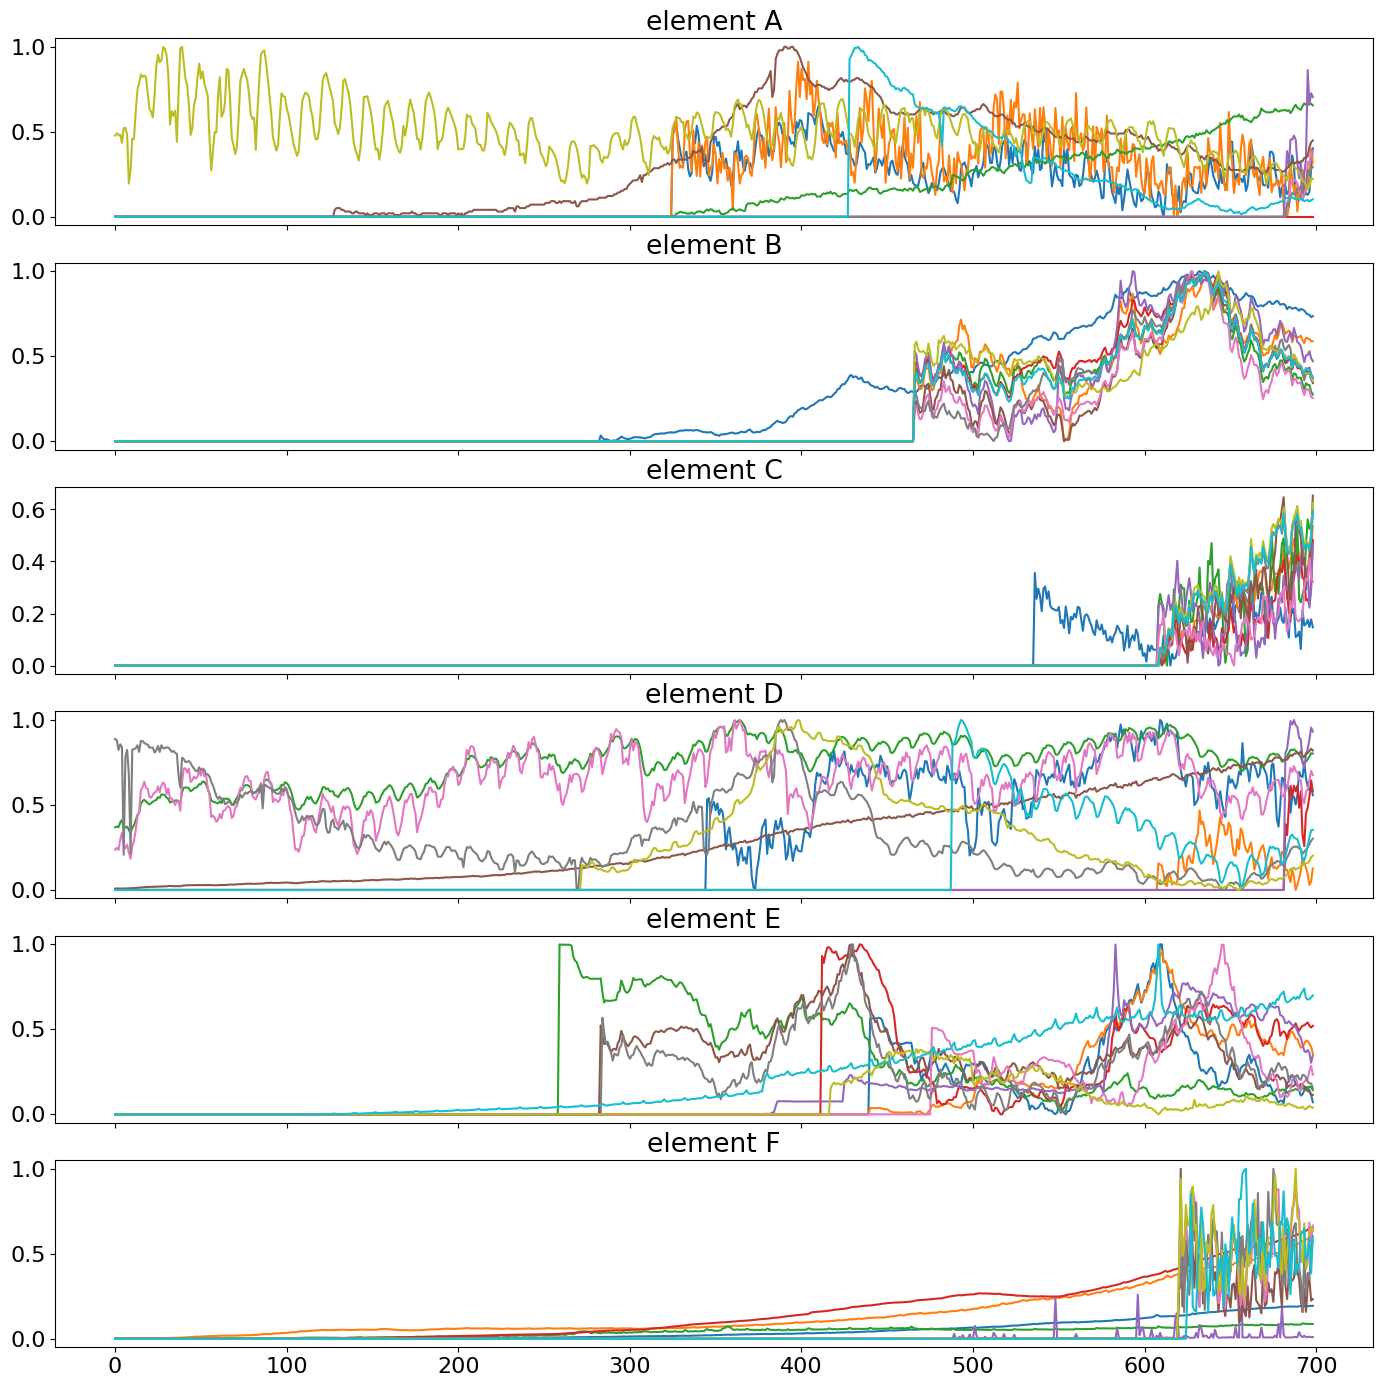

In [62]:
# Create a figure with subplots
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(17, 17))

# Plot each element's time-series data
elements_sorted = ['D', 'E', 'A', 'C', 'B', 'F']
starting_index = [0, 10016, 20991, 26719, 36736, 47723]

elements = ['A', 'B', 'C', 'D', 'E', 'F']
num_elements = [5728, 10987, 10017, 10016, 10975, 277]
prev_values = 0;
k = 0;
ind = 0

for i in range(6):
  j = starting_index[i]
  for k in range(j , j+10):
    axs[i].plot(ds[k][2000:2699])

  print(f"i : {k} allocated to element : {categories[k]}")
  axs[i].set_title(f'element {elements[i]}')
plt.show()

In [63]:
# # Compute class weights based on the original time series lengths
# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(integer_labels),
#                                      y=integer_labels)

# # Create a dictionary mapping class indices to class weights
# class_weights_dict = dict(zip(np.unique(integer_labels), class_weights))

# print("Class Weights:", class_weights_dict)

**Calculate ACF for each row & visualize result**

(43,)


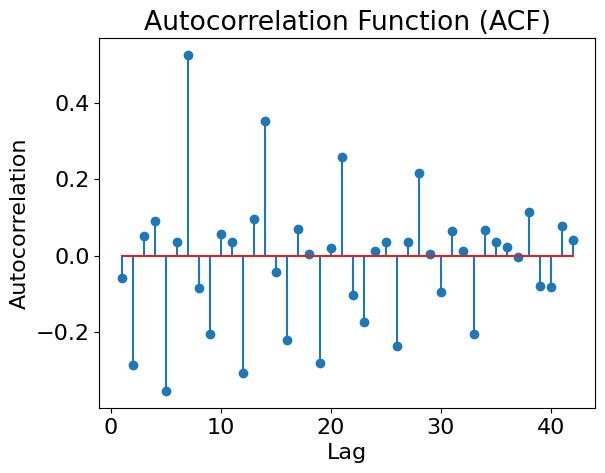

In [64]:
acf_values_all = []
for i, (start, end) in enumerate(valid_periods):
    acf_values = acf(original_dataset[i], nlags=len(np.arange(1, len(original_dataset[i]))))
    acf_values_all.append(acf_values)
    
def identify_significant_lags(acf_values):
    """Identifies the significant lags in the autocorrelation function (ACF)."""
    significant_lags = []
    for index, value in enumerate(acf_values):
        if abs(value) > 0.2:
            significant_lags.append(index)
    return significant_lags
significant_lags_all = []
for acf_values in acf_values_all:
    significant_lags = identify_significant_lags(acf_values)
    significant_lags_all.extend(significant_lags)
    
single_time_series = original_dataset[47800]
print(single_time_series.shape)
# Calculate autocorrelation function
lags = np.arange(1, len(single_time_series))
acf_values = acf(single_time_series, nlags=len(lags))

# Plot ACF
plt.stem(lags, acf_values[1:])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

**Normalization**

In [65]:
# scaler = RobustScaler()

# scaler.fit(np.concatenate(original_dataset).reshape(-1,1))
# dump(scaler, open('/kaggle/input/scalar/scaler.pkl', 'wb'))

scaler = load(open('/kaggle/input/scalar/scaler.pkl', 'rb'))
dataset_scaled = [scaler.transform(row.reshape(-1,1)).reshape(-1) for row in original_dataset]

Text(0, 0.5, 'Frequency')

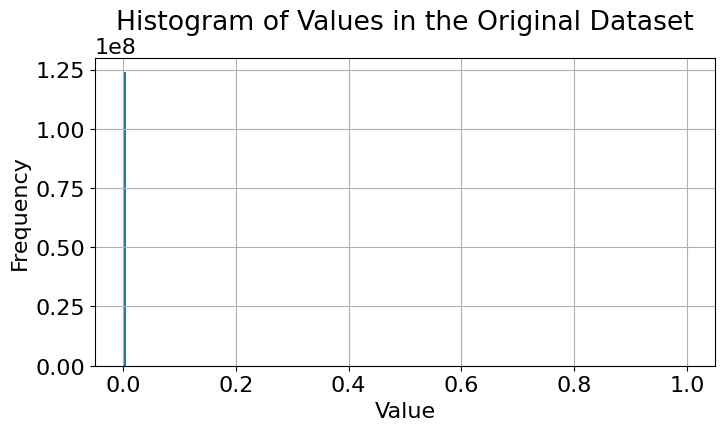

In [66]:
plt.figure(figsize=(8,4))
pd.Series(ds.reshape(-1)).hist(bins=200)

plt.title("Histogram of Values in the Original Dataset")
plt.xlabel('Value')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

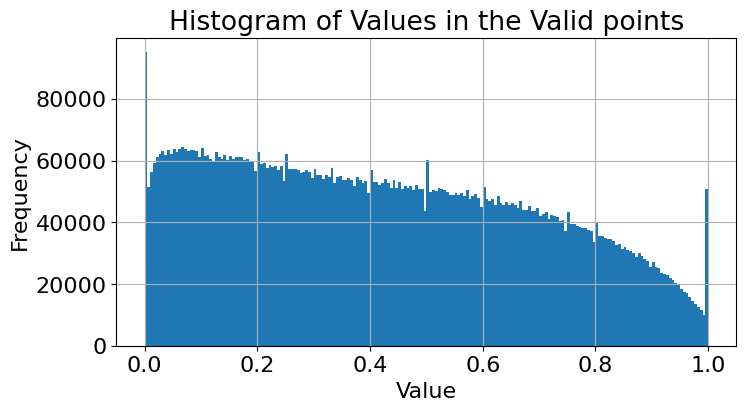

In [67]:
plt.figure(figsize=(8,4))
pd.Series(np.concatenate(original_dataset)).hist(bins=200)

plt.title("Histogram of Values in the Valid points")
plt.xlabel('Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

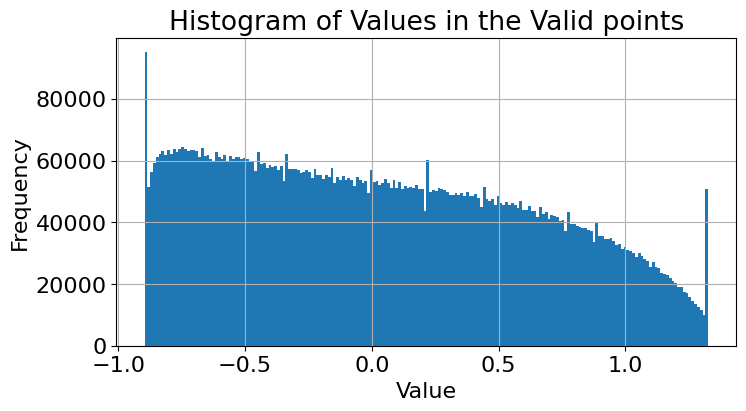

In [68]:
plt.figure(figsize=(8,4))
pd.Series(np.concatenate(dataset_scaled)).hist(bins=200)

plt.title("Histogram of Values in the Valid points")
plt.xlabel('Value')
plt.ylabel('Frequency')

# Preparatin of DATA for Network

In [69]:
def build_sequences(original_dataset, integer_labels, window=200, stride=100, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    predictions = []
    labels = []
    for i, row in enumerate(original_dataset):
        padding_len = window - len(original_dataset[i])%window
        original_dataset[i] = np.pad(original_dataset[i], (padding_len, 0), mode='constant', constant_values=0)
        for idx in np.arange(0,len(original_dataset[i])-window-telescope,stride):
            dataset.append(original_dataset[i][idx:idx+window].reshape((window, 1)))
            predictions.append(original_dataset[i][idx+window:idx+window+telescope].reshape((telescope, 1)))
            labels.append(integer_labels[i])
    dataset = np.array(dataset)
    predictions = np.array(predictions)
    labels = np.array(labels)
    return dataset, predictions, labels

* ***Initial Values***

In [70]:
batch_size = 64
epochs = 200

window= 60
stride = 20
telescope = 18

* ***split***

In [71]:
direct_telescope = telescope
X_train, y_train, labels = build_sequences(dataset_scaled, integer_labels, window, stride, direct_telescope)
X_train.shape ,  y_train.shape, labels.shape

((389247, 60, 1), (389247, 18, 1), (389247,))

* ***class weight***

In [72]:
# Compute class weights based on the new build_sequences time series
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(integer_labels),
                                     y=labels)

# Create a dictionary mapping class indices to class weights
class_weights_dict = dict(zip(np.unique(integer_labels), class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.9285428027538036, 1: 0.906321598211791, 2: 0.7288696394665588, 3: 0.7220552717397354, 4: 0.9720336824440748, 5: 29.42154195011338}


* ***visualize***

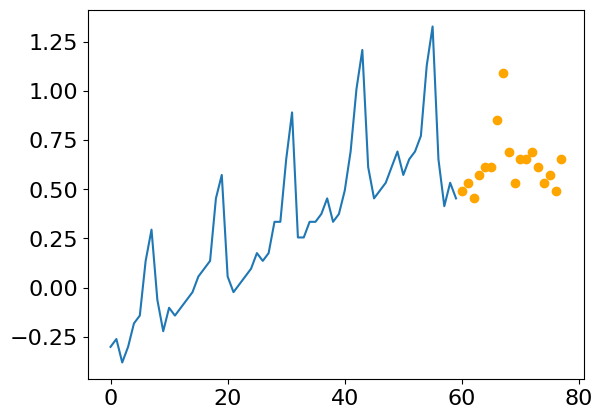

In [73]:
def inspect_univariate(X, y, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

        plt.plot(np.arange(len(X[0,:,:])), X[idx,:,:])
        plt.scatter(np.arange(len(X[0,:,:]), len(X_train[0,:,:])+telescope), y[idx,:,:], color='orange')
    plt.show()

inspect_univariate(X_train, y_train, telescope)

In [74]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

# Define The Models

In [75]:
def build_LSTM_model(input_shape, output_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    LSTM1 = tfkl.LSTM(256, return_sequences=True)(input_layer)
    LSTM1 = tfkl.LSTM(128, return_sequences=False)(LSTM1)
    # x = tfkl.GlobalAveragePooling1D()(x)

    LSTM1 = tfkl.Dense(64, activation='relu')(LSTM1)
    LSTM1 = tfkl.Dropout(0.2)(LSTM1)
    LSTM1 = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(LSTM1)
    LSTM1 = tfkl.Reshape((output_shape[-2],output_shape[-1]))(LSTM1)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(LSTM1)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [76]:
def build_LSTM_model_1(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    LSTM1 = tfkl.LSTM(64, return_sequences=True)(input_layer)
    LSTM1 = tfkl.LSTM(128, return_sequences=True)(LSTM1)

    Skip_LSTM = tfkl.LSTM(64, return_sequences=True)(input_layer)
    Skip_LSTM = tfkl.LSTM(128, return_sequences=True)(Skip_LSTM)

    LSTM1 = tfkl.GlobalAveragePooling1D()(LSTM1)
    Skip_LSTM = tfkl.GlobalAveragePooling1D()(Skip_LSTM)
    
    LSTM1 = tfkl.BatchNormalization()(LSTM1)

    LSTM1 = tfkl.Dropout(.6,seed=seed)(LSTM1)
    Skip_LSTM = tfkl.Dropout(.2,seed=seed)(Skip_LSTM)

    flatt=tfkl.concatenate([LSTM1,Skip_LSTM])
    
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(flatt)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [77]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a LSTM layer with 64 units
    LSTM = tfkl.LSTM(64, return_sequences=True, name='LSTM_1')(input_layer)
    LSTM = tfkl.LSTM(128, return_sequences=True, name='LSTM_2')(LSTM)
    LSTM = tfkl.BatchNormalization(name='BatchNormalization_1')(LSTM)
    
    # Add 2 skip_LSTM layer with 34 units
    Skip_LSTM = tfkl.LSTM(64, return_sequences=True, name='Skip_LSTM_1')(input_layer)
    Skip_LSTM_1 = tfkl.LSTM(64, return_sequences=True, name='Skip_LSTM_2')(input_layer)
    
    # Add a 1D Convolution layer with 128 filters and a kernel size of 5
    LSTM = tfkl.Conv1D(128, 5, padding='same', activation='relu', name='conv_1')(LSTM)
    LSTM = tfkl.Conv1D(128, 5, padding='same', activation='relu', name='conv_2')(LSTM)
    LSTM = tfkl.BatchNormalization(name='BatchNormalization_4')(LSTM)
        
    # add GlobalAveragePooling
    LSTM = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling_3')(LSTM)
    Skip_LSTM = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling_1')(Skip_LSTM)
    Skip_LSTM_1 = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling_2')(Skip_LSTM_1)
    
    #add BatchNormalization
    Skip_LSTM = tfkl.BatchNormalization(name='BatchNormalization_2')(Skip_LSTM)
    Skip_LSTM_1 = tfkl.BatchNormalization(name='BatchNormalization_3')(Skip_LSTM_1)
    
    #add Dropout
    LSTM = tfkl.Dropout(.75,seed=seed, name='Dropout_1')(LSTM)
    Skip_LSTM = tfkl.Dropout(.25,seed=seed, name='Dropout_2')(Skip_LSTM)
    Skip_LSTM_1 = tfkl.Dropout(.25,seed=seed, name='Dropout_3')(Skip_LSTM_1)

    flatt=tfkl.concatenate([LSTM,Skip_LSTM,Skip_LSTM_1], name='concatenate')

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu', name='dense')(flatt)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]), name='Reshape')(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same', name='Conv')(output_layer)


    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

    return model

In [78]:
def build_BidirectionalLSTM_model(input_shape, output_shape):
    
    # 2 bidirectional LSTM and one dense
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    bilstm1 = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    dropout1 = tfkl.Dropout(.3, seed=seed)(bilstm1)
    bilstm2 = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=False))(dropout1)
    dropout2 = tfkl.Dropout(.3, seed=seed)(bilstm2)
    
    dense1 = tfkl.Dense(512)(dropout2)

    dense2 = tfkl.Dense(output_shape[-1]*output_shape[-2], kernel_initializer = tfk.initializers.GlorotUniform(seed))(dense1)
    leaky_relu_layer = tfkl.LeakyReLU()(dense2)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(leaky_relu_layer)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [79]:
# building Multi-Head Attention based model
def build_attention_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    layer = MultiHeadAttention(num_heads=30, key_dim=12, value_dim=8)(input_layer,input_layer,input_layer)

    flatt2 = tfkl.Flatten()(layer)
    layer = tfkl.Dropout(.2)(flatt2)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(layer)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [80]:
def build_Attention_LSTM_model(input_shape, Output_shape):

    input_layer = tfk.Input(shape=input_shape, name='input_layer')
    Attention = tfkl.MultiHeadAttention(num_heads = 10, key_dim = 20, value_dim =20, output_shape = 10)(input_layer,input_layer,input_layer)
    LSTM_1 = tfkl.Bidirectional(tfkl.LSTM(64,return_sequences = True ))(input_layer)
    LSTM_2 = tfkl.Bidirectional(tfkl.LSTM(64,return_sequences = True ))(LSTM_1)
    skip_LSTM = tfkl.LSTM(128,return_sequences = True)(input_layer)
    Attention = tfkl.GlobalAveragePooling1D()(Attention)
    LSTM_2 = tfkl.GlobalAveragePooling1D()(LSTM_2)
    skip_LSTM = tfkl.GlobalAveragePooling1D()(skip_LSTM)
    
    
    LSTM_2 = tfkl.Dropout(.3)(LSTM_2)
    skip_LSTM = tfkl.Dropout(.3)(skip_LSTM)

    flatt=tfkl.concatenate([Attention,LSTM_2,skip_LSTM])
    
    # Connect input and output through the Model class
    dense = tfkl.Dense(Output_shape[-1]*Output_shape[-2], activation='relu')(flatt)
    output_layer = tfkl.Reshape((Output_shape[-2],Output_shape[-1]))(dense)

    output_layer = tfkl.Conv1D(Output_shape[-1], 1, padding='same')(output_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [81]:
#encoder part of the trasformer
def transformer_encoder(inputs, key_dim, num_heads, value_dim, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, value_dim=value_dim, dropout=dropout
    )(x, x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1)(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [82]:
# building the transformer by adding the decoding part

def build_TF_model(
    input_shape,
    key_dim,
    num_heads,
    value_dim,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    input_layer = tfk.Input(shape=input_shape, name='Input')
    x = input_layer
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, key_dim, num_heads, value_dim, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
        
    x = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(x)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(x)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    
    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae','acc'])
    
    return model

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 60, 1)]              0         []                            
                                                                                                  
 LSTM_1 (LSTM)               (None, 60, 64)               16896     ['input_layer[0][0]']         
                                                                                                  
 LSTM_2 (LSTM)               (None, 60, 128)              98816     ['LSTM_1[0][0]']              
                                                                                                  
 BatchNormalization_1 (Batc  (None, 60, 128)              512       ['LSTM_2[0][0]']              
 hNormalization)                                                                    

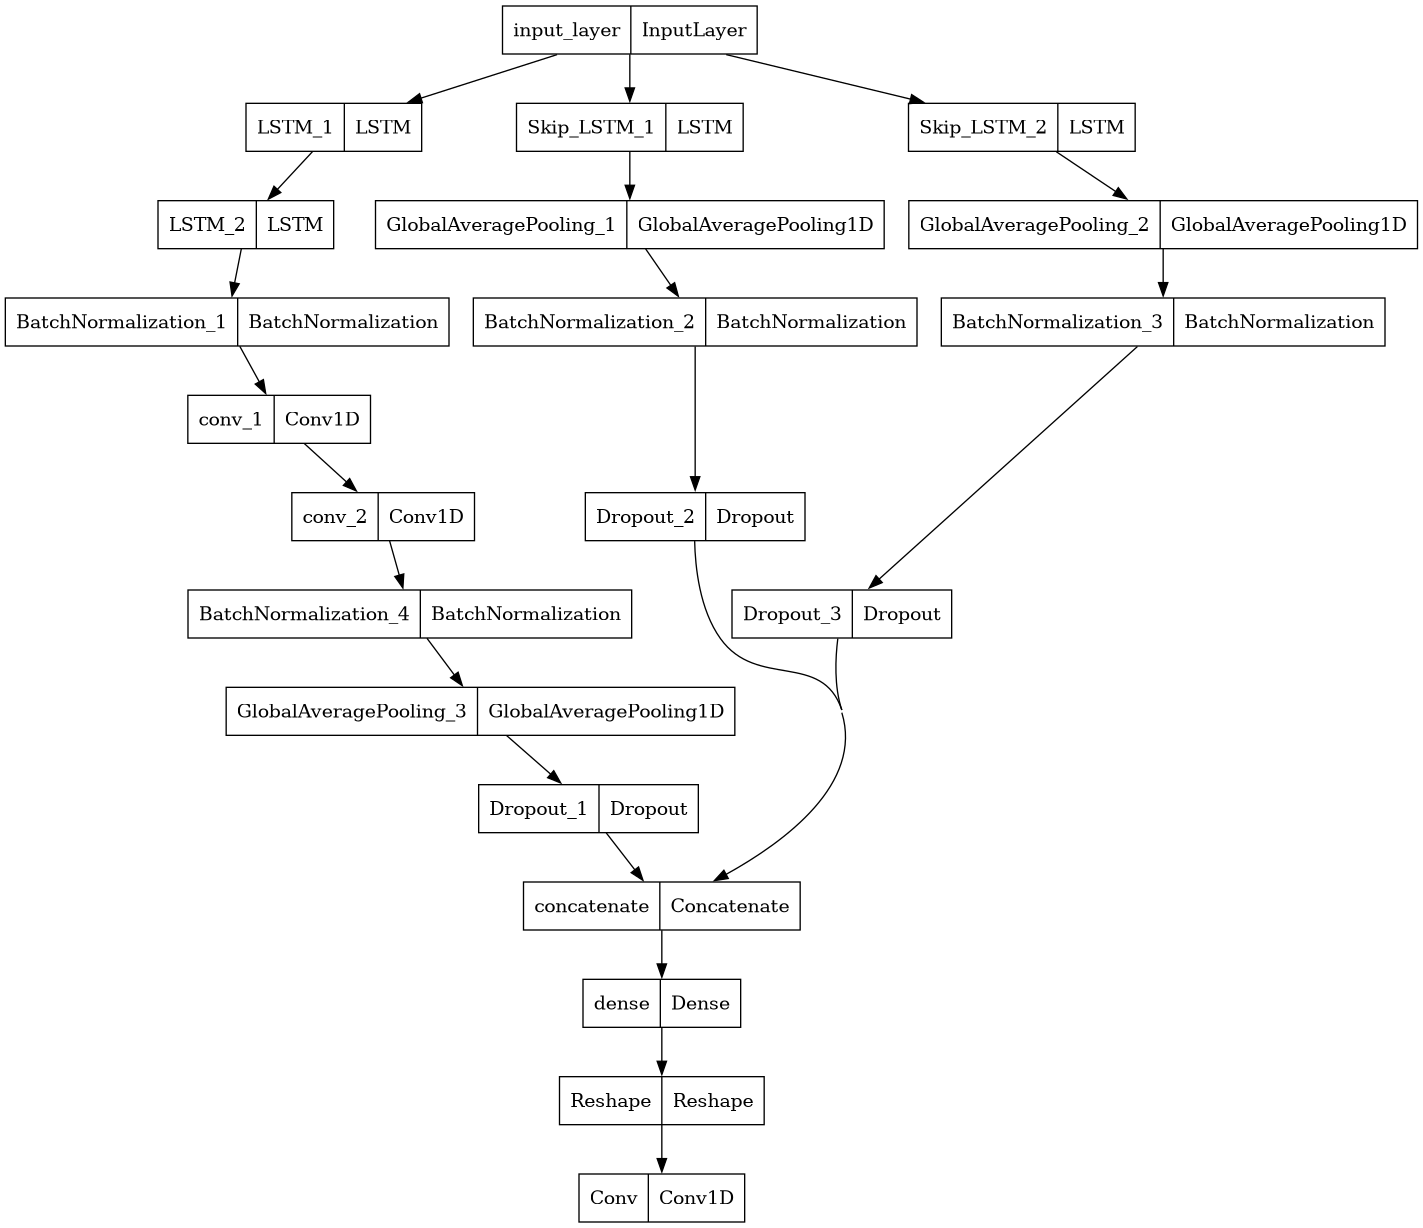

In [83]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Train the Model

In [84]:
#  Utility function for callbacks for training
learning_rate_reduction = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
#  Model early stop
EarlyStopping_point = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

In [85]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
#     class_weight=class_weights_dict,
    callbacks = [ EarlyStopping_point, learning_rate_reduction ]
).history

Epoch 1/200
5170/5170 [==============================] - 109s 19ms/step - loss: 0.1102 - mae: 0.2429 - val_loss: 0.1351 - val_mae: 0.2813 - lr: 0.0010
Epoch 2/200
2272/5170 [============>.................] - ETA: 50s - loss: 0.0759 - mae: 0.1986

KeyboardInterrupt: 

# Plot MAE MSE

In [ ]:
# plotting the loss and learning rate 
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# save the model
model.save('/kaggle/working/lstm1_bi')

from shutil import make_archive
make_archive('/kaggle/working/lstm1_bi', 'zip', '/kaggle/working/lstm1_bi')

# Autoregression

In [ ]:
autoregressive_telescope = 3
assert autoregressive_telescope < telescope

In [ ]:
X_trainA, y_trainA, labels = build_sequences(original_dataset, integer_labels, window, stride, autoregressive_telescope)
X_trainA.shape, y_trainA.shape

In [ ]:
inspect_univariate(X_trainA, y_trainA, autoregressive_telescope)

In [ ]:
input_shape = X_trainA.shape[1:]
output_shape = y_trainA.shape[1:]

In [ ]:
model_A = build_LSTM_model(input_shape, output_shape)
model_A.summary()

In [ ]:
# Train the model
history = model_A.fit(
    x = X_trainA,
    y = y_trainA,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
#     class_weight=class_weights_dict,
    callbacks = [ EarlyStopping_point, learning_rate_reduction ]
).history

# Plot MAE & MSE

In [ ]:
# plotting the loss and learning rate 
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# save the model
model_A.save('/kaggle/working/lstm1_5')

from shutil import make_archive
make_archive('/kaggle/working/lstm1_5', 'zip', '/kaggle/working/lstm1_5')